<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY" data-toc-modified-id="IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY</a></span><ul class="toc-item"><li><span><a href="#Air-quality-Data-Exploration-and-Cleanup" data-toc-modified-id="Air-quality-Data-Exploration-and-Cleanup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air quality Data Exploration and Cleanup</a></span><ul class="toc-item"><li><span><a href="#Import-datasets-and-overview-of-the-air-quality-data" data-toc-modified-id="Import-datasets-and-overview-of-the-air-quality-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import datasets and overview of the air quality data</a></span></li><li><span><a href="#Slice-and-dice-the-data-to-clean-up" data-toc-modified-id="Slice-and-dice-the-data-to-clean-up-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Slice and dice the data to clean up</a></span></li><li><span><a href="#Explore-the-data-through-graphs" data-toc-modified-id="Explore-the-data-through-graphs-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Explore the data through graphs</a></span></li></ul></li><li><span><a href="#COVID-19-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-DATA-EXPLORATION-AND-CLEAN-UP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>COVID-19 DATA EXPLORATION AND CLEAN UP</a></span></li><li><span><a href="#COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP</a></span></li></ul></li></ul></div>

# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Air quality Data Exploration and Cleanup

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint

# Import API key
from config import api_key

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

### Import datasets and overview of the air quality data

In [1]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

NameError: name 'pd' is not defined

* **parse_dates**
* ** 

In [ ]:
airdf_2019_2020 = pd.concat(df_list, ignore_index=True)

In [ ]:
airdf_2019_2020.head()

### Slice and dice the data to clean up

In [ ]:
# Display an overview of the Specie column
airdf_2019_2020["Specie"].unique()

In [ ]:
airdf_2019_2020["Specie"].value_counts()

> We understand that "Air movements influence the fate of air pollutants. So any study of air pollution should include a study of the local weather patterns (meteorology). If the air is calm and pollutants cannot disperse, then the concentration of these pollutants will build up. On the other hand, when strong, turbulent winds blow, pollutants disperse quickly, resulting in lower pollutant concentrations." https://www.qld.gov.au/environment/pollution/monitoring/air/air-monitoring/meteorology-influence/meteorology-factors#:~:text=Meteorological%20factors-,Meteorological%20factors,these%20pollutants%20will%20build%20up.
Hence the Meteorology parameters like temperature, humidity, pressure, wind speed, to name a few, should have some sorts of correlations with the air quality.
(http://www.bom.gov.au/vic/observations/melbourne.shtml)

> However, due to the scope of our project, we'll only focus on air pollutant parameters to assess their changes before COVID-19 and 6 months into the pandemic. We're not trying to explain the causes of air quality change. Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**.
https://aqicn.org/publishingdata/

> We'll also remove species with the least number of available data points  including **pol, pm1, mepaqi, neph**.

In [ ]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "uvi", "pol", "pm1", "mepaqi", "neph"]

clean_airdf = airdf_2019_2020[~airdf_2019_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [ ]:
clean_airdf.head()

In [ ]:
clean_airdf["Specie"].value_counts()

More about AQI:
https://www.airnow.gov/aqi/aqi-basics/
https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
"Five major pollutants:
EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

* Ground-level ozone **o3** (ppm - parts per million)
* Particulate Matter - including PM2.5 **pm25** and PM10 **pm10** (μg/m3)
* Carbon Monoxide **co** (ppm)
* Sulfur Dioxide **so2** (ppb - parts per billion)
* Nitrogen Dioxide **no2** (ppb)

https://en.wikipedia.org/wiki/Air_pollution

"https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/


https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1
https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [ ]:
clean_airdf.info()

We can see that the Date column is of generic object type. Since we want to perform some time related analysis on this data, we need to convert it to a datetime format. Let’s use to_datetime() function to convert the Date column into a datetime object. 

In [ ]:
clean_airdf["Date"] = pd.to_datetime(clean_airdf["Date"], format="%d/%m/%Y")

In [ ]:
clean_airdf.info()

In [ ]:
# Find the earliest date the air quality dataset covers:
clean_airdf["Date"].min()

In [ ]:
# Find the latest date the air quality dataset covers:
clean_airdf["Date"].max()

In [ ]:
clean_airdf["Country"].unique()

In [ ]:
# Display an overview of the Country column
country_airdata_df = pd.DataFrame(clean_airdf["Country"].unique(), columns=["country_code"])
country_airdata_df

There are 95 countries in the dataframe, including Australia (AU)....

In [ ]:
# Display an overview of the City column
clean_airdf["City"].unique()

In [ ]:
clean_airdf["City"].value_counts()

There are 615 cities in our dataframe. Let's see what cities in Australia covered in the dataset.

In [ ]:
clean_airdf.loc[clean_airdf["Country"]=="AU", "City"].value_counts()

### Explore the data through graphs

In [ ]:
unique_species = clean_airdf["Specie"].unique()
unique_species

In [ ]:
def specie_median_distribution(df, country):

    country_air_df = df[df["Country"] == country]

    fig, ax = plt.subplots(
        figsize=(10, 3*len(unique_species)),
        ncols=1,
        nrows=len(unique_species)
        )

    for index, specie in enumerate(unique_species):
        red_square=dict(markerfacecolor='r', marker='s', alpha=0.4)

        country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
country_air_df[country_air_df["Specie"] == specie].boxplot(
            column="median",
            flierprops=red_square,
            ax=ax[index],
            vert=False)

In [ ]:
au_air_df = clean_airdf[clean_airdf["Country"]==]

In [ ]:
        ax[index].set_title=f"Distribution of median {specie} values in {country} (2019-2020H1)"

In [ ]:
specie_median_distribution(clean_airdf, "AU")

In [ ]:
variance_0_df = clean_airdf[cleanclean_airdf["variance"]==0]
variance_0_df

In [ ]:
clean_airdf[clean_airdf["Specie"]=="pm25"]

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm25") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "no2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="no2") & (clean_airdf["median"]>=150)]

In [ ]:
specie_median_distribution(clean_airdf, "pm10")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="pm10") & (clean_airdf["median"]>=800)]

In [ ]:
specie_median_distribution(clean_airdf, "o3")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="o3") & (clean_airdf["median"]>=350)]

In [ ]:
specie_median_distribution(clean_airdf, "so2")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="so2") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "co")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="co") & (clean_airdf["median"]>=300)]

In [ ]:
specie_median_distribution(clean_airdf, "aqi")

In [ ]:
clean_airdf[(clean_airdf["Specie"]=="aqi") & (clean_airdf["median"]>=350)]

In [ ]:
variance_0_df["Country"].unique()

## COVID-19 DATA EXPLORATION AND CLEAN UP

Covid-19 is sourced from here https://covid19api.com/

In [ ]:
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

In [ ]:
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

In [ ]:
# Merge countries available on the air quality data and the covid data
country_covid_air_df = pd.merge(
    country_airdata_df, country_covid_df, how="left", left_on="country_code", right_on="ISO2")
country_covid_air_df

In [ ]:
# Find the country in the country_airdata_df but not country_covid_df
country_to_remove = country_covid_air_df[country_covid_air_df["ISO2"].isna()]["country_code"].tolist()
country_to_remove

In [ ]:
final_airdf = clean_airdf[~clean_airdf["Country"].isin(country_to_remove)].copy()

In [ ]:
final_airdf["Country"].nunique()

In [ ]:
final_airdf.to_csv("air_data.csv", index=False)

In [ ]:
country_covid_air_df

In [ ]:
del country_covid_air_df["ISO2"]

In [ ]:
# Return a dataframe covering all countries in both the air quality data and covid-19 data.
country_covid_air_df = country_covid_air_df[~country_covid_air_df["country_code"].isin(
    country_to_remove)].reset_index()
country_covid_air_df

In [ ]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

The above api example covers covid-19 data until 4th July 2020. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through our country_covid_air_df as above.

In [ ]:
slug_list = country_covid_air_df["Slug"].tolist()
len(slug_list)

In [ ]:
base_covid_url = "https://api.covid19api.com/total/country/"
    
country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:
    
    try:
        response = requests.get(base_covid_url + slug).json()
    
        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

In [ ]:
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

In [ ]:
covid_df.info()

In [ ]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [ ]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
covid_df["Date"].max()

In [ ]:
covid_df.info()

In [ ]:
covid_df.to_csv("covid_data.csv", index=False)

## COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP

In [3]:
au_covid_url = "https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json"
au_covid_data = requests.get(au_covid_url).json()
pprint(au_covid_data)

{'sheets': {'about': [{'about': 'This data has been compiled by Guardian '
                                'Australia from official state and territory '
                                'media releases and websites. Some death dates '
                                'and figures are from media reports. We assign '
                                'cases to the date on which they were reported '
                                'by the health department, and deaths are '
                                'assigned to the date they occured. Extended '
                                'data on testing and demographics varies '
                                'between each state and territory so may not '
                                'always be available. Please contact '
                                'australia.coronatracking@theguardian.com if '
                                'you spot an error in the data or to make a '
                                'suggestion. This data is released

                        'Details': '76 year old woman - Resident of Anglicare '
                                   'Newmarch House (14th death)',
                        'Name (if known)': '',
                        'Source': 'media release (Anglicare)',
                        'State': 'NSW'},
                       {'Date of death': '30/04/2020',
                        'Date reported': '03/05/2020',
                        'Death No (in state)': '9',
                        'Details': '83 year old woman - admitted to hospital '
                                   'mid-April',
                        'Name (if known)': '',
                        'Source': 'press conference',
                        'State': 'WA'},
                       {'Date of death': '',
                        'Date reported': '04/05/2020',
                        'Death No (in state)': '45',
                        'Details': 'male resident of Anglicare Newmarch House '
                                   '(15t

                         'Time': '',
                         'Update Source': 'NSW Health',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '4',
                         'Cumulative deaths': '',
                         'Date': '11/02/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '691',
                         'Time': '',
                         'Update Source': 'NSW Health',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '4',
                         'Cumulative deaths': '',
                         'Date': '12/02/2020',
                         'Hosp

                         'Date': '09/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'WA',
                         'Tests conducted (negative)': '1796',
                         'Tests conducted (total)': '1802',
                         'Time': '',
                         'Update Source': '',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '15',
                         'Cumulative deaths': '',
                         'Date': '09/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'VIC',
                         'Tests conducted (ne

                        {'Cumulative case count': '267',
                         'Cumulative deaths': '5',
                         'Date': '18/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'NSW',
                         'Tests conducted (negative)': '33387',
                         'Tests conducted (total)': '35800',
                         'Time': '11:00',
                         'Update Source': 'NSW Health',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '4',
                         'Cumulative deaths': '',
                         'Date': '19/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                

                        {'Cumulative case count': '1405',
                         'Cumulative deaths': '',
                         'Date': '26/03/2020',
                         'Hospitalisations (count)': '134',
                         'Intensive care (count)': '19',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'NSW',
                         'Tests conducted (negative)': '76284',
                         'Tests conducted (total)': '77689',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '58',
                         'Cumulative deaths': '',
                         'Date': '27/03/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
       

                         'Date': '02/04/2020',
                         'Hospitalisations (count)': '2',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '92',
                         'State': 'WA',
                         'Tests conducted (negative)': '15790',
                         'Tests conducted (total)': '16190',
                         'Time': '18:45',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '781',
                         'Cumulative deaths': '3',
                         'Date': '02/04/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'QLD',
                    

                         'Date': '11/04/2020',
                         'Hospitalisations (count)': '44',
                         'Intensive care (count)': '15',
                         'Notes': '',
                         'Recovered (cumulative)': '986',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '10:00',
                         'Update Source': 'press release',
                         'Ventilator usage (count)': '0'},
                        {'Cumulative case count': '2857',
                         'Cumulative deaths': '24',
                         'Date': '11/04/2020',
                         'Hospitalisations (count)': '78',
                         'Intensive care (count)': '30',
                         'Notes': '',
                         'Recovered (cumulative)': '1356',
                         'State': 'NSW',
              

                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '435',
                         'State': 'WA',
                         'Tests conducted (negative)': '28924',
                         'Tests conducted (total)': '',
                         'Time': '16:50',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '435',
                         'Cumulative deaths': '',
                         'Date': '20/04/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '363',
                         'State': 'SA',
                         'Tests conducted (negative)': '',
            

                         'Cumulative deaths': '41',
                         'Date': '28/04/2020',
                         'Hospitalisations (count)': '136',
                         'Intensive care (count)': '17',
                         'Notes': '',
                         'Recovered (cumulative)': '2266',
                         'State': 'NSW',
                         'Tests conducted (negative)': '209643',
                         'Tests conducted (total)': '212659',
                         'Time': '20:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '14'},
                        {'Cumulative case count': '1354',
                         'Cumulative deaths': '18',
                         'Date': '29/04/2020',
                         'Hospitalisations (count)': '18',
                         'Intensive care (count)': '9',
                         'Notes': '',
                         'Recovered (cumulative)

                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '552',
                         'Cumulative deaths': '',
                         'Date': '08/05/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '534',
                         'State': 'WA',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '',
                         'Time': '14:10',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '107',
                         'Cumulative deaths': '3',
                         'Date': '08/05/2020',
                         'Hospitalisations (count)':

                         'Hospitalisations (count)': '10',
                         'Intensive care (count)': '5',
                         'Notes': '',
                         'Recovered (cumulative)': '1473',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '378000',
                         'Time': '12:15',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '107',
                         'Cumulative deaths': '',
                         'Date': '21/05/2020',
                         'Hospitalisations (count)': '',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '104',
                         'State': 'ACT',
                         'Tests conducted (negative)': '14916',


                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '521000',
                         'Time': '11:30',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative case count': '1059',
                         'Cumulative deaths': '',
                         'Date': '02/06/2020',
                         'Hospitalisations (count)': '2',
                         'Intensive care (count)': '',
                         'Notes': '',
                         'Recovered (cumulative)': '',
                         'State': 'QLD',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '200391',
                         'Time': '17:30',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': ''},
                        {'Cumulative c

                         'Intensive care (count)': '0',
                         'Notes': '',
                         'Recovered (cumulative)': '592',
                         'State': 'WA',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '143418',
                         'Time': '17:00',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '0'},
                        {'Cumulative case count': '228',
                         'Cumulative deaths': '',
                         'Date': '17/06/2020',
                         'Hospitalisations (count)': '0',
                         'Intensive care (count)': '0',
                         'Notes': '',
                         'Recovered (cumulative)': '215',
                         'State': 'TAS',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '42395',
  

                         'Intensive care (count)': '3',
                         'Notes': '',
                         'Recovered (cumulative)': '1971',
                         'State': 'VIC',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '928100',
                         'Time': '15:28',
                         'Update Source': 'media release',
                         'Ventilator usage (count)': '0'},
                        {'Cumulative case count': '3240',
                         'Cumulative deaths': '',
                         'Date': '05/07/2020',
                         'Hospitalisations (count)': '69',
                         'Intensive care (count)': '1',
                         'Notes': '',
                         'Recovered (cumulative)': '2799',
                         'State': 'NSW',
                         'Tests conducted (negative)': '',
                         'Tests conducted (total)': '95398

In [4]:
au_covid_data.keys()

dict_keys(['sheets'])

In [5]:
au_covid_data['sheets'].keys()

dict_keys(['updates', 'deaths', 'latest totals', 'locations', 'sources', 'about', 'data validation'])

In [6]:
covid_by_state = au_covid_data['sheets']['updates']
covid_by_state[-1]

{'State': 'VIC',
 'Date': '07/07/2020',
 'Time': '13:00',
 'Cumulative case count': '2824',
 'Cumulative deaths': '',
 'Tests conducted (negative)': '',
 'Tests conducted (total)': '979000',
 'Hospitalisations (count)': '35',
 'Intensive care (count)': '9',
 'Ventilator usage (count)': '0',
 'Recovered (cumulative)': '2028',
 'Update Source': 'media release',
 'Notes': ''}

In [7]:
state_list = list()
date_list = list()
cumulative_case_count = list()
cumulative_recovered_count = list()

for element in covid_by_state:
    state_list.append(element["State"])
    date_list.append(element["Date"])
    cumulative_case_count.append(element["Cumulative case count"])
    cumulative_recovered_count.append(element["Recovered (cumulative)"])

In [8]:
au_covid_df = pd.DataFrame({
    "State": state_list,
    "Date": date_list,
    "Cumulative case count": cumulative_case_count,
    "Cumulative recovered count": cumulative_recovered_count
})
au_covid_df.head()

,State,Date,Cumulative case count,Cumulative recovered count
0,SA,23/01/2020,0,
1,VIC,25/01/2020,1,
2,NSW,25/01/2020,3,
3,NSW,27/01/2020,4,
4,QLD,28/01/2020,0,


In [9]:
au_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   State                       870 non-null    object
 1   Date                        870 non-null    object
 2   Cumulative case count       870 non-null    object
 3   Cumulative recovered count  870 non-null    object
dtypes: object(4)
memory usage: 27.3+ KB


In [10]:
au_covid_df["Cumulative case count"] = pd.to_numeric(au_covid_df["Cumulative case count"])

In [11]:
au_covid_df["Cumulative recovered count"] = pd.to_numeric(au_covid_df["Cumulative recovered count"].str.replace(",", ""))

In [12]:
# Convert the Date column to datetime format
au_covid_df['Date'] = pd.to_datetime(au_covid_df["Date"], format="%d/%m/%Y")

In [13]:
au_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       870 non-null    object        
 1   Date                        870 non-null    datetime64[ns]
 2   Cumulative case count       841 non-null    float64       
 3   Cumulative recovered count  434 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 27.3+ KB


In [15]:
vic_covid_df = au_covid_df[au_covid_df["State"]=="VIC"]
vic_covid_df

,State,Date,Cumulative case count,Cumulative recovered count
1,VIC,2020-01-25,1.0,NaN
7,VIC,2020-01-29,2.0,NaN
9,VIC,2020-01-30,3.0,NaN
15,VIC,2020-02-01,4.0,NaN
55,VIC,2020-03-01,9.0,NaN
...,...,...,...,...
853,VIC,2020-07-03,2368.0,1904.0
860,VIC,2020-07-04,2469.0,1938.0
863,VIC,2020-07-05,2536.0,1971.0
865,VIC,2020-07-06,2660.0,1992.0


In [19]:
sorted_vic_df = vic_covid_df.sort_values("Date", ignore_index=True)
sorted_vic_df

,State,Date,Cumulative case count,Cumulative recovered count
0,VIC,2020-01-25,1.0,NaN
1,VIC,2020-01-29,2.0,NaN
2,VIC,2020-01-30,3.0,NaN
3,VIC,2020-02-01,4.0,NaN
4,VIC,2020-03-01,9.0,NaN
...,...,...,...,...
127,VIC,2020-07-03,2368.0,1904.0
128,VIC,2020-07-04,2469.0,1938.0
129,VIC,2020-07-05,2536.0,1971.0
130,VIC,2020-07-06,2660.0,1992.0


In [20]:
sorted_vic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       132 non-null    object        
 1   Date                        132 non-null    datetime64[ns]
 2   Cumulative case count       131 non-null    float64       
 3   Cumulative recovered count  91 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.2+ KB


In [23]:
sorted_vic_df.fillna(method="ffill", inplace=True)

In [24]:
sorted_vic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       132 non-null    object        
 1   Date                        132 non-null    datetime64[ns]
 2   Cumulative case count       132 non-null    float64       
 3   Cumulative recovered count  110 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.2+ KB


In [25]:
sorted_vic_df.fillna(0, inplace=True)

In [28]:
sorted_vic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       132 non-null    object        
 1   Date                        132 non-null    datetime64[ns]
 2   Cumulative case count       132 non-null    float64       
 3   Cumulative recovered count  132 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.2+ KB


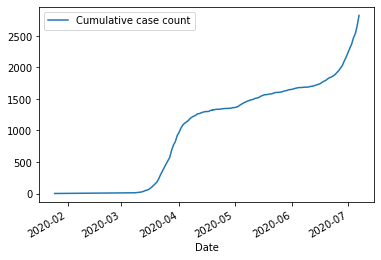

In [32]:
sorted_vic_df.plot(x="Date", y="Cumulative case count")

In [ ]:
sorted_au_covid = au_covid_df.sort_values(["State", "Date"], ignore_index=True)
sorted_au_covid.head()

In [ ]:
filled_au_covid = sorted_au_covid.fillna(method='ffill')

In [ ]:
filled_au_covid.info()

In [ ]:
filled_au_covid.fillna(0, inplace=True)

In [ ]:
filled_au_covid.info()

In [ ]:
filled_au_covid.head()

In [ ]:
filled_au_covid[["Cumulative case count", "Cumulative recovered count"]] = filled_au_covid[[
    "Cumulative case count", "Cumulative recovered count"]].astype(int)

In [ ]:
filled_au_covid.info()

In [ ]:
# Find the earliest date the covid dataset covers:
filled_au_covid["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
filled_au_covid["Date"].max()

In [ ]:
# Set cutoff time on 5th July 2020
final_au_covid =  filled_au_covid[filled_au_covid["Date"] <= "2020-07-05"].copy()

In [ ]:
vic_covid_data = filled_au_covid[filled_au_covid["State"]=="VIC"]
vic_covid_data

In [ ]:
clean_au_covid.info()

In [ ]:
final_au_covid.to_csv("au_covid_data.csv", index=False)

In [ ]:
# import time
# from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

In [ ]:
# url = "https://api.openaq.org/v1/measurements"

# data = requests.get(url).json()
# pprint(data)

In [ ]:
# len(data["results"])

In [ ]:
# data["results"][0]

In [ ]:
# Data source: https://aqicn.org/api/
# base_url = "https://api.waqi.info/feed/"
# city = "melbourne"
# url = f"{base_url}{city}/?token={api_key}"

In [ ]:
# url_2 = "https://api.covid19api.com/country/south-africa/status/confirmed/live"
# covid_data_2 = requests.get(url_2).json()
# pprint(covid_data_2[-1])